# Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

In [1]:
#!pip install transformers
#!pip3 install torchvision
#!pip3 install catboost
#!pip3 install lightgbm


In [2]:
#!pip3 install jupyterthemes 

In [3]:
#!jt -r

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import notebook

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import torch
import transformers
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

In [5]:
df = pd.read_csv('D:/Загрузки/toxic_comments.csv')

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
print('Количество дублей в датасете:', df.duplicated().sum())

Количество дублей в датасете: 0


В датасете два столбца и 159 571 строк. Пропусков и дубликатов нет.

(-1.25, 1.25, -1.25, 1.25)

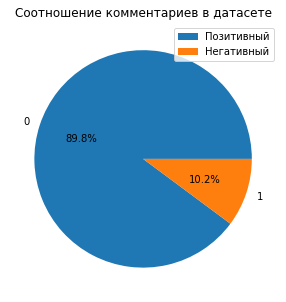

In [9]:
#Смотрим на соотношение позитивных и негативных комментариев
df['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.legend(['Позитивный','Негативный'])
plt.title('Соотношение комментариев в датасете')
plt.axis('off')

Негативных комментариев 10.2%, позитивных же 89.8%

Возьмем из выборки 1 000 случайных записей, чтобы не создавать эмбеддинги и сделаем негативные и позитивные комментарии в соотношении 50/50.

(-1.25, 1.25, -1.25, 1.25)

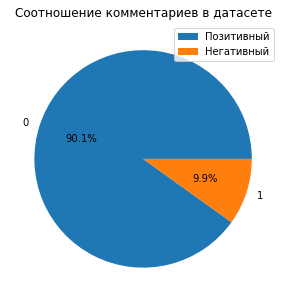

In [10]:
batch_df = df.sample(1000, random_state=12345).reset_index(drop=True)

#проверим на соотношение позитивных и негативных комментариев
batch_df['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.legend(['Позитивный','Негативный'])
plt.title('Соотношение комментариев в датасете')
plt.axis('off')

В данном датасете Позитивных комментариев 90.1%, негативных же 9.9%

In [11]:
#возьмем уже обученную модель для выявления токсичных комментариев
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = batch_df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

#инициализируем саму модель класса BertModel
model = AutoModel.from_pretrained('unitary/toxic-bert')

(1000, 512)


Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
%%time

#эмбеддинги модель BERT создаёт батчами. Из-за мощьностей компьютера, сделаем размер батча небольшим
batch_size = 100

#пустой список для хранения эмбеддингов
embeddings = []


#цикл по батчам. Отображать прогресс будет функция notebook
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        # преобразуем данные в формат тензоров
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            #чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # преобразуем элементы методом numpy() к типу numpy.array
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 13min 9s


In [14]:
#создадим обучающую, валидационную и тестовую выборки в соотношении 3:1:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print('Размер обучающей выборки:', len(target_train))
print('Размер тестовой выборки:', len(target_test))
print('Размер валидационной выборки:', len(target_valid))

Размер обучающей выборки: 600
Размер тестовой выборки: 200
Размер валидационной выборки: 200


# Обучение модели

## логистическая регрессия

In [22]:
%%time


logistic_model = LogisticRegression(random_state=12345, solver='saga')
logistic_model.fit(features_train, target_train)

print('F1 логистической регрессии:', cross_val_score(
    logistic_model, features_valid, target_valid, cv=5, scoring='f1').mean())

D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


F1 логистической регрессии: 0.96
Wall time: 1.15 s


D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Случайный лес

In [31]:
%%time


forest_model = RandomForestClassifier(random_state=12345)
forest_params = {'n_estimators':range(9, 45, 9), 'max_depth':range(10, 20)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring='f1', n_jobs=-1)
forest_grid.fit(features_train, target_train)

print('Лучшие параметры случайного леса:', forest_grid.best_params_)
print('F1 случайного леса составляет:',  cross_val_score(
    forest_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Лучшие параметры случайного леса: {'max_depth': 10, 'n_estimators': 18}
F1 случайного леса составляет: 0.9714285714285715
Wall time: 7.2 s


### Catboost

In [16]:
%%time



cat_model = CatBoostClassifier(iterations=100, verbose=False, random_state=12345)
cat_params = {'learning_rate':[0.05, 0.1], #скорость обучения
              'depth':[5, 7]} #depth - глубина дерева
cat_grid = GridSearchCV(cat_model, cat_params, cv=3, scoring='f1', n_jobs=-1)
cat_grid.fit(features_train, target_train)

print('Лучшие параметры Catboost:', cat_grid.best_params_)
print('F1 Catboost составляет:', cross_val_score(
    cat_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Лучшие параметры Catboost: {'depth': 5, 'learning_rate': 0.05}
F1 Catboost составляет: 0.8647619047619047
Wall time: 4min 10s


### LightGBM

In [17]:
%%time



gbm_model = LGBMClassifier(random_state=12345)
gbm_params = {'n_estimators':[100, 150], #количество деревьев решений
              'num_leaves':[10, 15, 20]} #количество терминальных узлов (листьев) дерева
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=5, scoring='f1', n_jobs=-1)
gbm_grid.fit(features_train, target_train)

print('Лучшие параметры LightGBM:', gbm_grid.best_params_)
print('F1 LightGBM составляет:', cross_val_score(
    gbm_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Лучшие параметры LightGBM: {'n_estimators': 150, 'num_leaves': 15}
F1 LightGBM составляет: 0.8571428571428571
Wall time: 29.3 s


Все модели показали отличный результат f1 и самый минимальный результат получился у LightGBM равный 0.857. При этом лучше всех оказался случайный лес с результатом 0.971. Его и проверим на тестовой выборке.

# Проверка адекватности модели

In [18]:
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(features_train, target_train)
dummy_clf_pred = dummy_clf.predict(features_train)
print('Accuracy:', dummy_clf.score(dummy_clf_pred, target_train))
print('F1 Dummy:', cross_val_score(dummy_clf, features_valid, target_valid, cv=5, scoring='f1').mean())

Accuracy: 0.9033333333333333
F1 Dummy: 0.0


F1 Dummy модели составляет 0.0, а accuracy составил 0.903

In [23]:
data={'Модель': ['Logistic Regression', 'RandomForest', 'Catboost', 'LightGBM', 'Dummy Model'],
      'F1:': [0.96, 0.971, 0.864, 0.857, 0.0]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,F1:
0,Logistic Regression,0.960
1,RandomForest,0.971
2,Catboost,0.864
3,LightGBM,0.857
4,Dummy Model,0.000


### Проверим логистическую регрессию с лучшими параметрами на тестовой выборке.

In [32]:
model = RandomForestClassifier(random_state=12345, n_estimators=18, max_depth=10)

model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('F1 случайного леса на тестовой выборке составляет:',  cross_val_score(
    model, features_valid, target_valid, cv=5, scoring='f1').mean())

F1 случайного леса на тестовой выборке составляет: 0.9028571428571428


Получили результат f1 равный 0.902

# Выводы

1. Для подготовки текста была использована предобученная нейросеть BERT.
2. Из всего датасета для создания эмбеддингов была взята выборка из 2 500 случайных записей.
3. Для обучения были выбраны 4 модели: логистическая регрессия, случайный лес, Catboost и LightGBM.
4. Все модели показали отличный результат f1.
5. Лучший результат показала модель случайного леса и на обучающей выборке был получен f1 равный 0.971